Imports

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import matplotlib as _  # ensure matplotlib inline
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit.transpiler import PassManager
from itertools import combinations, product
from tqdm.notebook import tqdm

from LogicalQ.Transpilation.UnBox import UnBoxTask

import copy
import numpy as np

Quickly verifying encoding works:

/Users/petrusinskaya_alice/Desktop/GT QCA/myenv/lib/python3.13/site-packages/qiskit/visualization/circuit/matplotlib.py:270: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /Users/petrusinskaya_alice/Desktop/GT QCA/myenv/lib/python3.13/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(


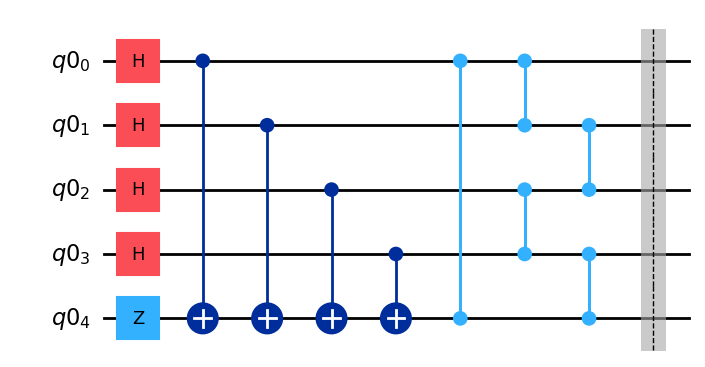

In [2]:
def encoding_circuit(circuit):
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.h(3)
    circuit.z(4)

    circuit.cx(0, 4)
    circuit.cx(1, 4)
    circuit.cx(2, 4)
    circuit.cx(3, 4)
    circuit.cz(0, 4)
    circuit.cz(0, 1)
    circuit.cz(2, 3)
    circuit.cz(1, 2)
    circuit.cz(3, 4)
    circuit.barrier()

# Create quantum circuit with 5 qubits
qreg = QuantumRegister(5)
circuit = QuantumCircuit(qreg)

# Apply encoding
encoding_circuit(circuit)

# Draw circuit using matplotlib
circuit.draw('mpl', style='iqx')

In [3]:
from qiskit.quantum_info import Statevector

# Returns the output statevector of the given circuit
statevec = Statevector.from_instruction(circuit.reverse_bits())
statevec.draw(output = 'latex')

<IPython.core.display.Latex object>

Stabilizer Measurements:

/Users/petrusinskaya_alice/Desktop/GT QCA/myenv/lib/python3.13/site-packages/qiskit/visualization/circuit/matplotlib.py:270: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /Users/petrusinskaya_alice/Desktop/GT QCA/myenv/lib/python3.13/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(


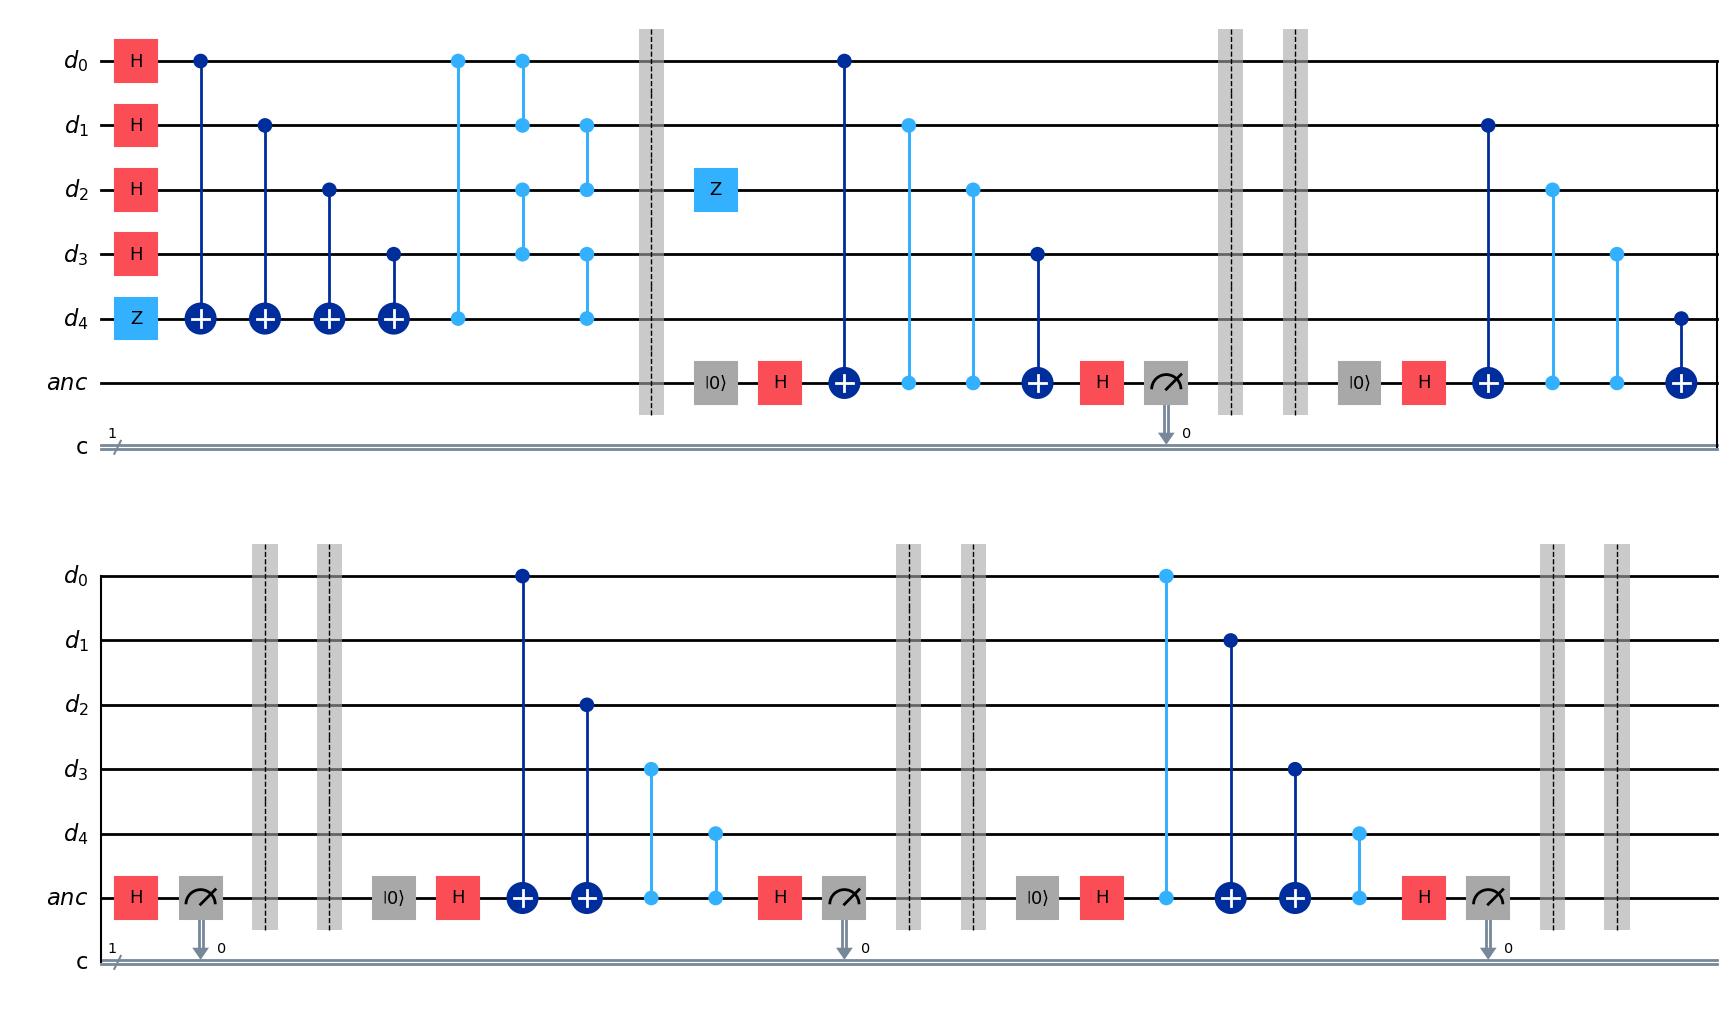

In [38]:
d_qubits = QuantumRegister(5, 'd')     
a_qubit = QuantumRegister(1, 'anc')     
c_bit = ClassicalRegister(1, 'c')        
qc = QuantumCircuit(d_qubits, a_qubit, c_bit)

stabilizers = [
    "XZZXI",
    "IXZZX",
    "XIXZZ",
    "ZXIXZ"
]

def encoding_circuit(qc, d):
    qc.h(d[0])
    qc.h(d[1])
    qc.h(d[2])
    qc.h(d[3])
    qc.z(d[4])

    qc.cx(d[0], d[4])
    qc.cx(d[1], d[4])
    qc.cx(d[2], d[4])
    qc.cx(d[3], d[4])
    qc.cz(d[0], d[4])
    qc.cz(d[0], d[1])
    qc.cz(d[2], d[3])
    qc.cz(d[1], d[2])
    qc.cz(d[3], d[4])
    qc.barrier()
    return qc

qc = encoding_circuit(qc, d_qubits)

qc.z(d_qubits[2])  # X-error

def measure_stabilizer(qc, stabilizer, d_qubits, a_qubit, c_bit):
    qc.reset(a_qubit[0])
    qc.h(a_qubit[0]) 

    for i, p in enumerate(stabilizer):
        if p == 'X':
            qc.cx(d_qubits[i], a_qubit[0])
        elif p == 'Z':
            qc.cz(d_qubits[i], a_qubit[0])

    qc.h(a_qubit[0])  
    qc.measure(a_qubit[0], c_bit[0])
    qc.barrier()

for s in stabilizers:
    measure_stabilizer(qc, s, d_qubits, a_qubit, c_bit)
    qc.barrier()

qc.draw('mpl', style='iqx')

#get counts

Syndrome Extraction

In [46]:
def generate_weight_n_errors(num_qubits: int, weight: int, pauli_ops: list[str] = ['X', 'Y', 'Z']) -> list[Pauli]:
    """
    Generates a list of all unique Qiskit Pauli objects of a specific weight.

    Args:
        num_qubits: The total number of qubits in the system.
        weight: The target weight of the Pauli errors to generate (N).
        pauli_ops: A list of single-qubit Pauli operators to use (e.g., ['X', 'Z']).
                   Defaults to ['X', 'Y', 'Z'].

    Returns:
        A list of Qiskit Pauli objects representing all unique weight-N errors.
        Returns an empty list if weight is invalid.
    """
    if not 0 < weight <= num_qubits:
        print(f"Error: Weight must be between 1 and {num_qubits}.")
        return []

    errors = set()
    
    qubit_indices_combinations = combinations(range(num_qubits), weight)
    for qubit_indices in qubit_indices_combinations:  
        gate_combinations_for_indices = product(pauli_ops, repeat=weight)

        for gates in gate_combinations_for_indices:
            pauli_list = ['I'] * num_qubits

            for i, gate in enumerate(gates):
                qubit_index = qubit_indices[i]
                pauli_list[qubit_index] = gate
            
            pauli_string = "".join(pauli_list[::-1])
            errors.add(Pauli(pauli_string))
    
    return list(errors)



def generate_syndrome_lookup_table(qecc, qc, data_qubits, a_qubit, c_bit, verbose = False):
    """
    Given a quantum error correction code (qecc), generates lookup table for brute force LUT decoder.
    """
    
    n, k, d = qecc["label"]
    stabilizers = qecc["stabilizer_tableau"]
    
    keys = [f'{x:0{len(stabilizers)}b}' for x in range(2**len(stabilizers))] # 0 is good, 1 is error
    #keys.remove("0" * len(stabilizers))
    
    lookup_table = {
        key: None for key in keys
    }
    
    simulator = AerSimulator()

    unbox_pm = PassManager([UnBoxTask()])
    base_circuit = QuantumCircuit(n)
    # base_circuit: QuantumCircuit = encoding_circuit(base_circuit, d_qubits)
    base_circuit = encoding_circuit(qc, data_qubits)
    
    if verbose:
        print("Generating error syndromes...")
    
    t = (d - 1) // 2
    for weight in range(1, 1 + t):
        errors = generate_weight_n_errors(n, weight)
        num_filled_entries = np.sum(bool(np.array(list(lookup_table.values()) == None)))
        
        if verbose:
            print(f"Percentage of entries filled: {num_filled_entries}/{len(keys)} = {np.round(num_filled_entries / len(keys), 2)}%")
            print(f"Iterating over weight {weight}")
        
        for error in tqdm(errors):
            qc = copy.deepcopy(base_circuit)
            qc.compose(error.to_instruction(), inplace=True)
            # qc = append_registers(qc, stabilizers)
            # qc = measure_stabilizer(qc, stabilizers)
            measure_stabilizer(qc, stabilizers, data_qubits, a_qubit, c_bit)
            
            transpiled_qc = unbox_pm.run(qc)
            transpiled_qc = transpile(transpiled_qc, simulator)
            result = simulator.run(transpiled_qc, shots=1).result()
            counts = result.get_counts()
            syndrome = str(list(counts.keys())[0][2:])
            if lookup_table[syndrome] == None:
                lookup_table[syndrome] = error
            elif verbose:
                print("Conflict")
                print("syndrome", syndrome)
                print(lookup_table[syndrome])
                print(error)
                
            is_lookup_table_filled = not any(v is None for v in lookup_table.values()) #bool(np.array(list(lookup_table.values()) == None).any())
            if is_lookup_table_filled:
                return lookup_table
            
    return {key: value for key, value in lookup_table.items() if value is not None}

In [47]:
code_513 = {
    "label": (5,1,3),
    "stabilizer_tableau": stabilizers,
}

lookup_table = generate_syndrome_lookup_table(code_513, qc, d_qubits, a_qubit, c_bit, True)
lookup_table

Generating error syndromes...
Percentage of entries filled: 0/16 = 0.0%
Iterating over weight 1


  0%|          | 0/15 [00:00<?, ?it/s]

KeyError: ''